
# Finite Differences for the Convection-Diffusion Equation

- Author: Lambert Theisen `lambert.theisen(AT)rwth-aachen.de`
- Class: Mathematische Grundlagen IV (SS2020)

The *Finite Difference Method* (FDM) is a numerical method to solve *Partial Differential Equations* (PDEs) approximately. We use second-order central finite differences for the diffusion term and investigate stability issue related to the discretization of the first-order advection term.

## Convection-Diffusion Problem

We want to solve the Convection-Diffusion equation

$$
\begin{aligned}
  - \epsilon \Delta u(x,y) + v \cdot \nabla u(x,y) &= f(x,y), & (x,y) & \in [0,L_x] \times [0, L_y] \\
  u(x,0) &= b(x), & x & \in [0,L] \\
  u(x,L) &= t(x), & x & \in [0,L] \\
  u(L,y) &= r(y), & y & \in [0,L] \\
  u(0,y) &= l(y), & y & \in [0,L] \\
\end{aligned}
$$

on a rectangle with $\epsilon>0$ and $v \in \mathbb{R}^2$. The domain is discreitized structurally with $N_x$ and $N_y$ grid-points per dimension leading to $h_x=\frac{1}{N_x-1}$ and $h_y=\frac{1}{N_y-1}$.


In [1]:
using LinearAlgebra
using SparseArrays
using PyPlot
using Plots



## Domain and Boundary Conditions

The domain $\bar{\Omega}$ $[0,L_x] \times [0,L_y]$ is split into the nodes $\{(x_i,y_j)\}_{i,j=0 \dots N} \in \bar{\Omega}_h$ with
$$
    x_i = \frac{L_x}{N_x-1} ,\quad y_j = \frac{L_y}{N_y-1}
$$
The interior nodes are $\{(x_i,y_j)\}_{i,j=1 \dots N-1} \in \Omega_h$.
We further need boundary conditions for all four sides of the unit square.


In [2]:
struct Rectangle
    Lx::Float64
    Ly::Float64
    Nx::Int64
    Ny::Int64
    hx::Float64
    hy::Float64
    xh::Array{Float64,1}
    yh::Array{Float64,1}
    function Rectangle(Lx, Ly, Nx, Ny)
        hx = Lx/(Nx-1)
        hy = Ly/(Ny-1)
        xh = range(0, Lx, step=hx)
        yh = range(0, Ly, step=hy)
        N = new(Lx, Ly, Nx, Ny, hx, hy, xh, yh)
    end
end

struct UnitSquareUniform
    function UnitSquareUniform(N)
        h = 1/(N-1)
        xh = range(0, 1, step=h)
        yh = range(0, 1, step=h)
        N = Rectangle(1., 1., N, N)
    end
end

test = UnitSquareUniform(10)
display(test)

struct RectangleBCs
    bot
    right
    top
    left
end


Rectangle(1.0, 1.0, 10, 10, 0.1111111111111111, 0.1111111111111111, [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0], [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0])


## Discretization Laplacian and First-Order Advection Term

We discretize the Laplacian using central finite differences with second order as
$$
    \Delta  u(x,y) = \frac{-u(x+h,y) - u(x-h,y) + 4u(x,y) - u(x,y+h) - u(x,y-h)}{h^2} + \mathcal{O}(h^2) \\
$$
such that the stencil for node values reads
$$
\begin{aligned}
    u_{i,j} & \approx \frac{-u_{i+1,j} - u_{i-1,j} + 4u_{i,j} -u_{i,j+1} -u_{i,j-1}}{h^2}
    \\ \Leftrightarrow
    [- \Delta u_h]_\xi &=
    \frac{1}{h^2}
    \begin{bmatrix}
         0 & -1 &  0 \\
        -1 &  4 & -1 \\
         0 & -1 &  0 \\
    \end{bmatrix}
    , \quad \xi \in \Omega_h
\end{aligned}
$$
We either use central finite differences or the upwind finite differences for the convection term (with $v_1^+ := \max{(0,v_1)}$ and $v_1^- := \min{(0,v_1)}$):
$$
    [v \cdot \nabla u_h^{up}]_\xi =
    \begin{bmatrix}
         0 & \frac{v_2^-}{h_y} &  0 \\
        \frac{-v_1^+}{h_x} & \frac{|v_1|}{h_x} + \frac{|v_2|}{h_y} & \frac{v_1^-}{h_x} \\
         0 & \frac{-v_2^+}{h_y} &  0 \\
    \end{bmatrix}
$$
$$
    [v \cdot \nabla u_h^{central}]_\xi =
    \frac{1}{h^2}
    \begin{bmatrix}
         0 & v_2 &  0 \\
        -v_1 & 0 & v_1 \\
         0 & -v_2 &  0 \\
    \end{bmatrix} (\text{FIXME: only for } h_x=h_y)
$$
TODO: Explain RHS vector and source vector


In [3]:
function Δₕ(Ω::Rectangle)
    ⊗ = kron
    dxx = spdiagm(-1=>ones(Ω.Nx-3), 0=>-2ones(Ω.Nx-2), 1=>ones(Ω.Nx-3))
    dyy = spdiagm(-1=>ones(Ω.Ny-3), 0=>-2ones(Ω.Ny-2), 1=>ones(Ω.Ny-3))
    return 1/Ω.hx^2 * I(Ω.Ny-2) ⊗ dxx + 1/Ω.hy^2 * dyy ⊗ I(Ω.Nx-2)
end

function v◦∇ₕ(Ω::Rectangle, v, use_upwind)
    ⊗ = kron
    if use_upwind
        v1dxLoc = 1/Ω.hx * spdiagm(
            -1=>-max(0,v[1])*ones(Ω.Nx-3),
            0=>abs(v[1])*ones(Ω.Nx-2),
            1=>min(0,v[1])*ones(Ω.Nx-3)
        )
        v2dyLoc = 1/Ω.hy * spdiagm(
            -1=>-max(0,v[2])*ones(Ω.Ny-3),
            0=>abs(v[2])*ones(Ω.Ny-2),
            1=>min(0,v[2])*ones(Ω.Ny-3)
        )
    else
        # central as default
        v1dxLoc = 1/Ω.hx^2 * spdiagm(
            -1=>-v[1]*ones(Ω.Nx-3),
            1=>v[1]*ones(Ω.Nx-3)
        )
        v2dyLoc = 1/Ω.hy^2 * spdiagm(
            -1=>-v[2]*ones(Ω.Ny-3),
            1=>v[2]*ones(Ω.Ny-3)
        )
    end
    return I(Ω.Ny-2) ⊗ v1dxLoc + v2dyLoc ⊗ I(Ω.Nx-2)
end

function bₕ(Ω::Rectangle, f, bcs::RectangleBCs)
    Nx = Ω.Nx
    Ny = Ω.Ny
    xInt = Ω.xh[2:end-1]
    yInt = Ω.yh[2:end-1]

    fh = vec(f.(xInt,yInt'))
    bh = 1/Ω.hy^2 .* vec(bcs.bot.(xInt))
    rh = 1/Ω.hx^2 .* vec(bcs.right.(yInt))
    th = 1/Ω.hy^2 .* vec(bcs.top.(xInt))
    lh = 1/Ω.hx^2 .* vec(bcs.left.(yInt))

    bvec = zeros((Nx-2)*(Ny-2))
    bvec += fh
    bvec[1                  : 1      : Nx-2] += bh
    bvec[(Nx-2)*(Ny-2-1)+1  : 1      : end] += th
    bvec[(Nx-2)             : (Nx-2) : end] += rh
    bvec[1                  : (Nx-2) : end] += lh

    return bvec
end

function solveConvDiff(Ω::Rectangle, f, v, ϵ, use_upwind, bcs::RectangleBCs)
    A = -ϵ*Δₕ(Ω) + v◦∇ₕ(Ω, v, use_upwind)
    b = bₕ(Ω, f, bcs)
    return (A) \ b
end

function plotSol(Ω::Rectangle, u, bcs::RectangleBCs, edgeAvg=true)
    pyplot()
    Nx = Ω.Nx
    Ny = Ω.Ny
    uMat = zeros(Nx,Ny)
    uMat[2:end-1,2:end-1] = reshape(u, (Nx-2, Ny-2))
    uMat[2:Nx-1,1] = vec(bcs.bot.(Ω.xh[2:end-1]))
    uMat[2:Nx-1,Ny] = vec(bcs.top.(Ω.xh[2:end-1]))
    uMat[Nx,2:Ny-1] = vec(bcs.right.(Ω.yh[2:end-1]))
    uMat[1,2:Ny-1] = vec(bcs.left.(Ω.yh[2:end-1]))
    if edgeAvg
        uMat[1,1] = 0.5 * (uMat[1,2] + uMat[2,1])
        uMat[1,Ny] = 0.5 * (uMat[1,Ny-1] + uMat[2,Ny])
        uMat[Nx,1] = 0.5 * (uMat[Nx-1,1] + uMat[Nx,2])
        uMat[Nx,Ny] = 0.5 * (uMat[Nx-1,Ny] + uMat[Nx-1,Ny])
    else
        uMat[1,1] = uMat[1,Ny] = uMat[Nx,1] = uMat[Nx,Ny] = 0
    end
    Plots.surface(Ω.xh, Ω.yh, uMat', camera=(35, 35), title="Plot")
end



plotSol (generic function with 2 methods)


## Experiments

- Show failure of central diffs for convection-dominated cases
- Show success for upwind diffs for arbitrary cases


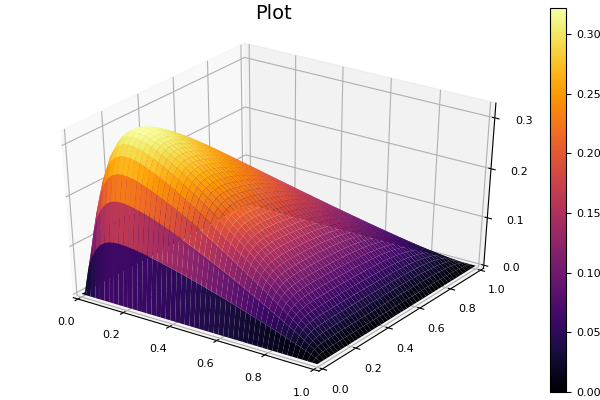

In [4]:
Ω = UnitSquareUniform(50)
bcs = RectangleBCs(x -> 0, y -> 0, x -> 0, y -> 0)
f(x,y) = 10
v = [-0.2, -0.2]
use_upwind = false

u_stable = solveConvDiff(Ω, f, v, 1E0, use_upwind, bcs)
plotSol(Ω, u_stable, bcs)


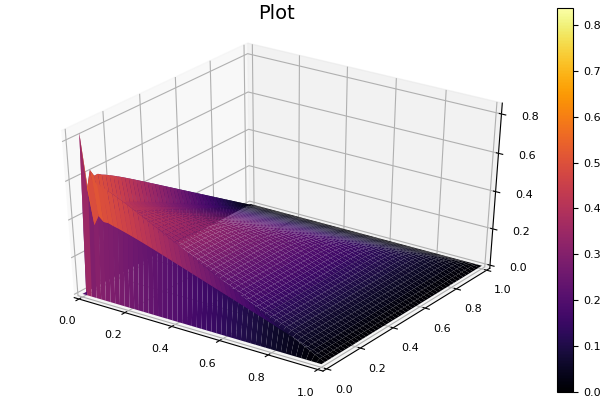

In [5]:
u_instable = solveConvDiff(Ω, f, v, 1E-1, use_upwind, bcs) # lower epsilon/v ratio
plotSol(Ω, u_instable, bcs)



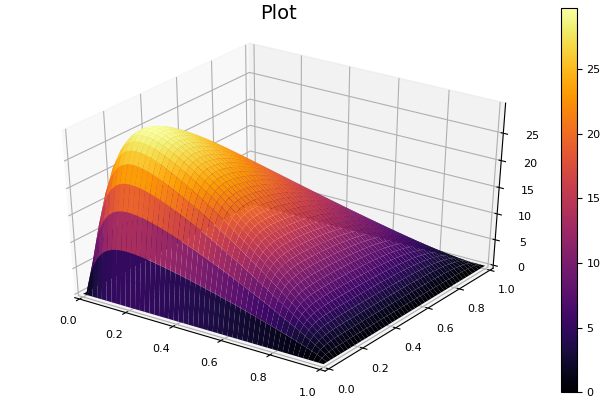

In [6]:
Ω = UnitSquareUniform(50)
bcs = RectangleBCs(x -> 0, y -> 0, x -> 0, y -> 0)
f(x,y) = 10
v = [-0.2, -0.2]
use_upwind = true

u_stable = solveConvDiff(Ω, f, v, 1E-2, use_upwind, bcs)
plotSol(Ω, u_stable, bcs)